# Ускорение тестирования

### Импорт библиотек

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

### Импорт данных

In [ ]:
data_path = "ab_speedup.csv"
data = pd.read_csv(data_path, index_col=0)
print("Размеры датасета", data.shape)
data.head(6)

Размеры датасета (50000, 2)


,group,metrica
strata,,
11,history,42.631346
6,history,14.844453
4,history,2.362768
37,history,79.494017
18,history,-22.627788
34,history,28.679378


In [3]:
data['group'].value_counts()

group
B          21430
A          21427
history     7143
Name: count, dtype: int64

<div class="alert alert-info">
<b>Про Датасет</b>
    
Датасет представляет собой результаты некоторого А/B-Теста. 

* `strata` - Некоторая информация по страту (группа), к которой относится пользователь. 
* `group` - Группа эксперимента - тестовая, контрольная или прошлая история. 
* `metrica` - Целивая метрика
    
</div>

In [4]:
history_data = data[data['group'] == 'history']
current_data = data[data['group'].isin(['A', 'B'])]

control = current_data[current_data['group'] == 'A']['metrica']
test = current_data[current_data['group'] == 'B']['metrica']

<div class="alert alert-info">

<b>Задание:</b>    
    
Найти различие между группами, увеличив чувствительность тестов тремя способами поочередно:
* Бутстрап
* Стратификация
* CUPED
    
Вспомогательная статья Валерия Бабушкина про стратификацию и CUPED:

* habr.com/ru/company/yandex/blog/497804/

In [5]:
def t_test(control, test):
    t_stat, p_value = stats.ttest_ind(test, control, equal_var=False)
    return t_stat, p_value

In [6]:
def bootstrap_test(control, test, n_bootstrap=5000, alpha=0.05, seed=42):
    np.random.seed(seed)

    diffs = []
    for _ in tqdm.tqdm(range(n_bootstrap), desc='Bootstrap'):
        new_control = np.random.choice(control, size=len(control), replace=True)
        new_test = np.random.choice(test, size=len(test), replace=True)
        diff = new_test.mean() - new_control.mean()
        diffs.append(diff)

    diffs = np.array(diffs)

    p_value = 2 * min(np.mean(diffs < 0), np.mean(diffs > 0))
    ci = np.percentile(diffs, [100 * alpha / 2, 100 * (1 - alpha / 2)])
    original_diff = test.mean() - control.mean()
    
    return p_value, ci, original_diff

In [7]:
def stratified_test(data, n_bootstrap=5000, alpha=0.05, seed=42):
    np.random.seed(seed)

    strata_list = data.index.unique()
    diffs = []
    
    for _ in tqdm.tqdm(range(n_bootstrap), desc='Stratified Bootstrap'):
        control_samples = []
        test_samples = []

        for stratum in strata_list:
            stratum_data = data.loc[stratum]

            control = stratum_data[stratum_data['group'] == 'A']['metrica']
            test = stratum_data[stratum_data['group'] == 'B']['metrica']

            new_control = np.random.choice(control, size=len(control), replace=True)
            new_test = np.random.choice(test, size=len(test), replace=True)
            control_samples.append(new_control)
            test_samples.append(new_test)
        
        full_control = np.concatenate(control_samples)
        full_test = np.concatenate(test_samples)
        diff = full_test.mean() - full_control.mean()
        diffs.append(diff)

    diffs = np.array(diffs)

    p_value = 2 * min(np.mean(diffs < 0), np.mean(diffs > 0))
    ci = np.percentile(diffs, [100 * alpha / 2, 100 * (1 - alpha / 2)])
    diff = diffs.mean()

    return p_value, ci, diff

In [8]:
def cuped_test(current_data, history_data, n_bootstrap=5000, alpha=0.05, seed=42):
    np.random.seed(seed)

    history_means = history_data.groupby(history_data.index)['metrica'].mean()
    
    current = current_data.copy()
    current['covariate'] = current.index.map(history_means)
    current.dropna(subset=['covariate'], inplace=True)

    strata_list = current.index.unique()
    adjusted_pieces = []
    
    for stratum in strata_list:
        stratum_data = current.loc[[stratum]]
        Y = stratum_data['metrica'].values
        X = stratum_data['covariate'].values

        if len(X) < 2 or np.var(X, ddof=1) == 0:
            stratum_data['metrica_cuped'] = Y
        else:
            theta = np.cov(Y, X, ddof=1)[0,1] / np.var(X, ddof=1)
            stratum_data['metrica_cuped'] = Y - theta * (X - X.mean())

        adjusted_pieces.append(stratum_data[['group', 'metrica_cuped']])

    adjusted_data = pd.concat(adjusted_pieces)

    diffs = []
    for _ in tqdm.tqdm(range(n_bootstrap), desc='CUPED Bootstrap'):
        control_samples = []
        test_samples = []

        for stratum in strata_list:
            stratum_data = adjusted_data.loc[stratum]

            control = stratum_data[stratum_data['group'] == 'A']['metrica_cuped']
            test = stratum_data[stratum_data['group'] == 'B']['metrica_cuped']

            new_control = np.random.choice(control, size=len(control), replace=True)
            new_test = np.random.choice(test, size=len(test), replace=True)

            control_samples.append(new_control)
            test_samples.append(new_test)

        full_control = np.concatenate(control_samples)
        full_test = np.concatenate(test_samples)
        diff = full_test.mean() - full_control.mean()
        diffs.append(diff)

    diffs = np.array(diffs)
    
    p_value = 2 * min(np.mean(diffs < 0), np.mean(diffs > 0))
    ci = np.percentile(diffs, [100 * alpha / 2, 100 * (1 - alpha / 2)])

    test_mean = adjusted_data[adjusted_data['group'] == 'B']['metrica_cuped'].mean()
    control_mean = adjusted_data[adjusted_data['group'] == 'A']['metrica_cuped'].mean()
    diff_cuped = test_mean - control_mean
    
    return p_value, ci, diff_cuped


In [9]:
results = {}

# T-test
t_stat, t_p_value = t_test(control, test)
results['t-test'] = t_p_value

print(f"T-test Result:")
print(f"\tt-statistic: {t_stat:.4f}")
print(f"\tp-value: {t_p_value:.4f}\n")

# Bootstrap
p_value_bootstrap, ci_bootstrap, diff_bootstrap = bootstrap_test(control, test)
results['bootstrap'] = p_value_bootstrap

print(f"Bootstrap Results:")
print(f"\tDifference in means: {diff_bootstrap:.4f}")
print(f"\t95% Confidence Interval: [{ci_bootstrap[0]:.4f}, {ci_bootstrap[1]:.4f}]")
print(f"\tp-value: {p_value_bootstrap:.4f}\n")

# Stratification
p_value_strat, ci_strat, diff_strat = stratified_test(data)
results['stratification'] = p_value_strat

print(f"Stratification Results:")
print(f"\tDifference in means: {diff_strat:.4f}")
print(f"\t95% Confidence Interval: [{ci_strat[0]:.4f}, {ci_strat[1]:.4f}]")
print(f"\tp-value: {p_value_strat:.4f}\n")

# CUPED
p_value_cuped, ci_cuped, diff_cuped = cuped_test(current_data, history_data)
results['CUPED'] = p_value_cuped

print(f"CUPED Results:")
print(f"\tDifference in means: {diff_cuped:.4f}")
print(f"\t95% Confidence Interval: [{ci_cuped[0]:.4f}, {ci_cuped[1]:.4f}]")
print(f"\tp-value: {p_value_cuped:.4f}\n")

T-test Result:
	t-statistic: -2.4980
	p-value: 0.0125



Bootstrap: 100%|██████████| 5000/5000 [00:02<00:00, 2017.69it/s]


Bootstrap Results:
	Difference in means: -0.8273
	95% Confidence Interval: [-1.5053, -0.1688]
	p-value: 0.0104



Stratified Bootstrap: 100%|██████████| 5000/5000 [01:26<00:00, 57.73it/s]


Stratification Results:
	Difference in means: -0.8246
	95% Confidence Interval: [-1.4214, -0.2219]
	p-value: 0.0056



CUPED Bootstrap: 100%|██████████| 5000/5000 [01:16<00:00, 65.03it/s]

CUPED Results:
	Difference in means: -0.8273
	95% Confidence Interval: [-1.4243, -0.2295]
	p-value: 0.0052



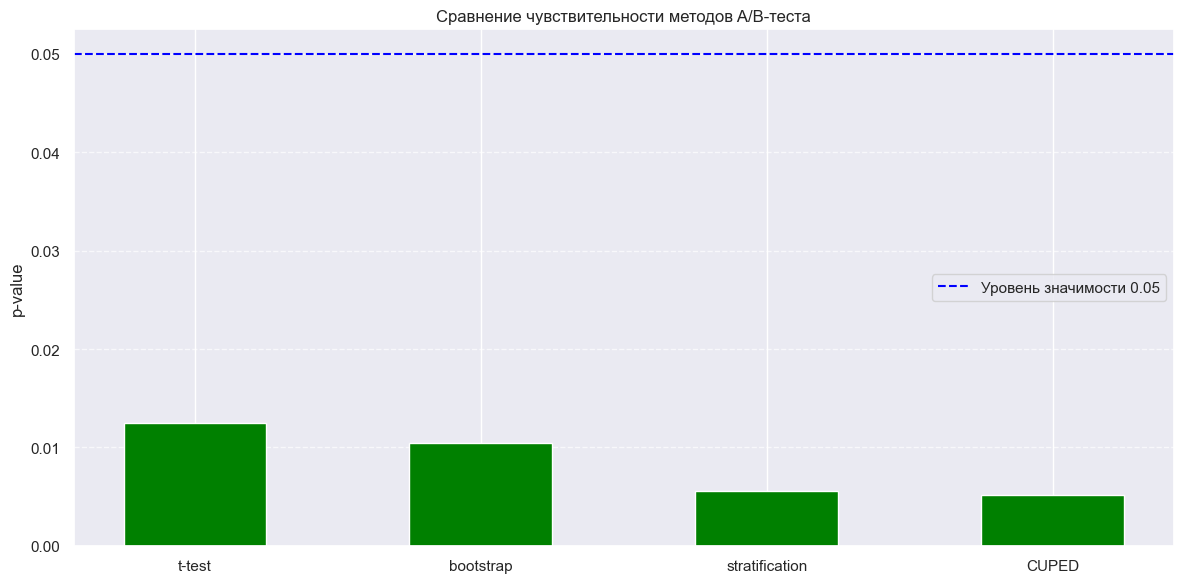

In [10]:
# Visualization
plt.figure(figsize=(12, 6))
methods = list(results.keys())
p_values = list(results.values())
colors = ['green' if p_value < 0.05 else 'red' for p_value in p_values]

plt.bar(methods, p_values, width=0.5, color=colors)
plt.axhline(0.05, color='blue', linestyle='--', label='Уровень значимости 0.05')
plt.ylabel('p-value')
plt.title('Сравнение чувствительности методов A/B-теста')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

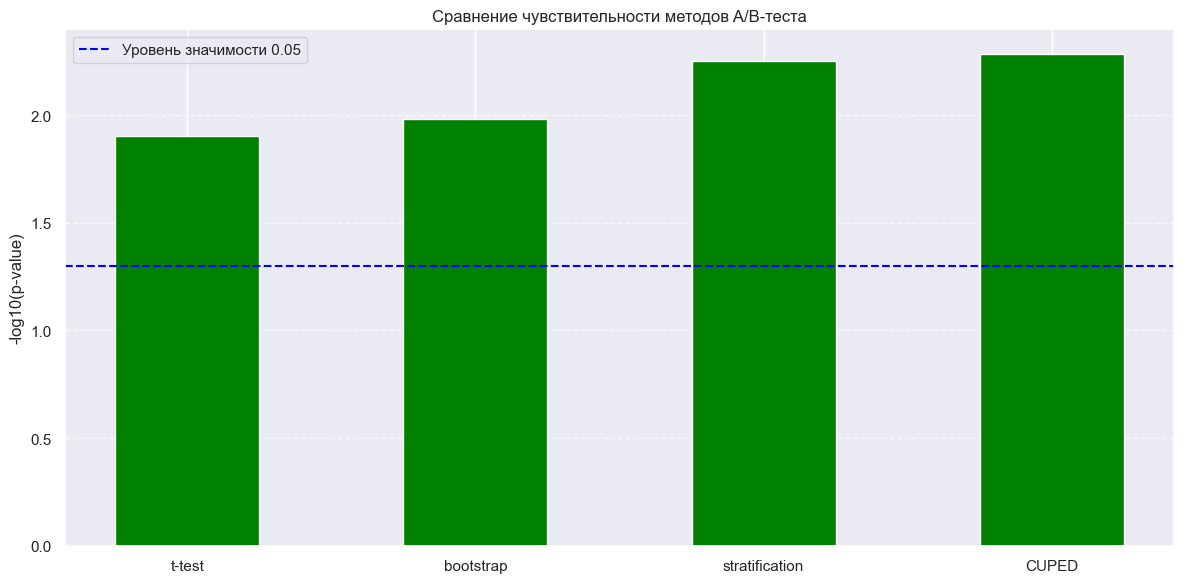

In [11]:
# Visualization
plt.figure(figsize=(12, 6))
methods = list(results.keys())
p_values = list(results.values())
colors = ['green' if p_value < 0.05 else 'red' for p_value in p_values]

plt.bar(methods, -np.log10(p_values), width=0.5, color=colors)
plt.axhline(-np.log10(0.05), color='blue', linestyle='--', label='Уровень значимости 0.05')
plt.ylabel('-log10(p-value)')
plt.title('Сравнение чувствительности методов A/B-теста')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Анализ результатов

### 1. **T-test**

**Результат:**
* t-статистика: -2.4980
* p-value: **0.0125**

**Пояснение:**
Обычный независимый t-критерий показал наличие статистически значимого различия между контрольной и тестовой группами на уровне значимости 0.05. Но p-value достаточно близок к границе, что указывает на умеренную чувствительность метода. Этот результат может быть нестабилен при изменении распределения данных.

---

### 2. **Bootstrap**

**Результат:**
* Разница средних: -0.8273
* 95% доверительный интервал: [-1.5053, -0.1688]
* p-value: **0.0104**

**Пояснение:**
Бутстрап позволяет оценивать доверительный интервал и p-value без предположений о нормальности выборки. Он подтверждает статистическую значимость, и даёт наглядный доверительный интервал для эффекта. При этом результат согласуется с t-тестом по направлению и значимости, но чуть более чувствителен, потому что p-value ниже.

---

### 3. **Stratification**

**Результат:**
* Разница средних: -0.8246
* 95% доверительный интервал: [-1.4214, -0.2219]
* p-value: **0.0056**

**Пояснение:**
Стратификация уменьшает дисперсию внутри групп. Она улучшает чувствительность критерия - p-value сильно снизился. Для более точного результата использовался бутстрап, что в совокупности дало более чувствительный результат.

---

### 4. **CUPED**

**Результат:**
* Разница средних: -0.8273
* 95% доверительный интервал: [-1.4243, -0.2295]
* p-value: **0.0052**

**Пояснение:**
Метод CUPED учитывает ковариаты, известные до эксперимента, и корректирует метрику, уменьшая дисперсию. Это приводит к максимальному снижению p-value, то есть к наибольшей чувствительности. Для получения ещё более точного анализа использовалась стратификация с бутстрапом, что в итоге привело к выводу, что результат согласуется по знаку и величине с методом бутстрапа и стратификации и достигает статистической значимости немного увереннее, чем остальные методы.

---

## Общий вывод:

| Метод          | p-value | Преимущество                        | Комментарий                           |
| -------------- | ------- | ----------------------------------- | ------------------------------------- |
| T-test         | 0.0125  | Простота, быстрая проверка гипотезы | Менее чувствителен                    |
| Bootstrap      | 0.0104  | Не требует нормальности             | Лучше, чем T-test                     |
| Stratification | 0.0056  | Учет неоднородности по стратам      | Значительно повышает чувствительность |
| CUPED          | 0.0052  | Учет ковариаты снижает дисперсию    | Самый чувствительный метод            |

* Все три метода значительно улучшают чувствительность по сравнению с классическим t-тестом.
* Все методы повышают чувствительность, различия — лишь в степени уверенности (p-value) и ширине доверительных интервалов.
* Все методы снижают дисперсию, но делают это немного по-разному: бутстрап устраняет зависимость от конкретной выборки, стратификация контролирует вариации внутри каждой страты, CUPED устраняет шум через ковариаты.
* Стратификация требует возможности значимого фактора для разбиения по стратам, CUPED требует знания исторических данных.
